In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 30
n_classes = 2

In [18]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    verbose=1,
    shuffle=True,
    class_names=['NORMAL', 'PNEUMONIA']
)

Found 5856 files belonging to 2 classes.


In [19]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

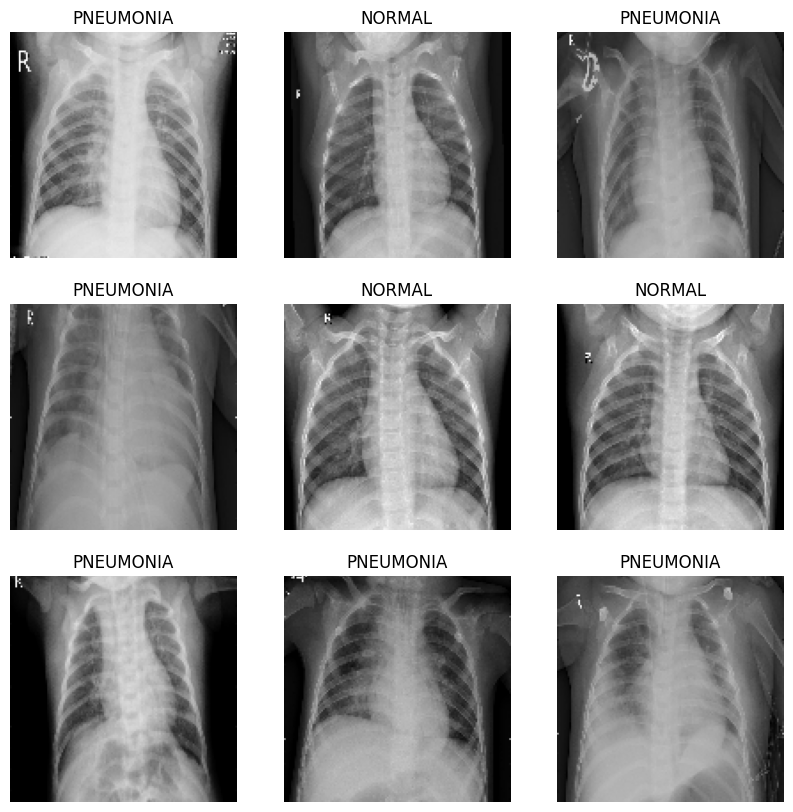

In [20]:
plt.figure(figsize=(10, 10))
for images_batch, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))

        # Convert one-hot encoded label to integer index
        label_index = tf.argmax(labels[i]).numpy()

        # Use the class_names list to get the corresponding class name
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
print("Length of train_ds:", len(train_ds))
print("Length of val_ds:", len(val_ds))
print("Length of test_ds:", len(test_ds))

Length of train_ds: 146
Length of val_ds: 18
Length of test_ds: 19


In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [26]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.05455729 0.05455729 0.05455729]
  [0.5610907  0.5610907  0.5610907 ]
  [0.00949755 0.00949755 0.00949755]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.86950827 0.86950827 0.86950827]
  [0.49122244 0.49122244 0.49122244]
  [0.03488817 0.03488817 0.03488817]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.01206342 0.01206342 0.01206342]
  [0.00505515 0.00505515 0.00505515]
  [0.         0.         0.        ]]

 ...

 [[0.08480392 0.08480392 0.08480392]
  [0.12980239 0.12980239 0.12980239]
  [0.06482077 0.06482077 0.06482077]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.10422028 0.10422028 0.10422028]
  [0.23645067 0.23645067 0.23645067]


### **Normalize the Image**

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

In [68]:
# Define input shape for model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [69]:
def build_model(input_shape, n_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        resize_and_rescale,
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    return model

model_1 = build_model(input_shape, n_classes)

In [70]:
model_1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,970 (6.48 MB)

 Trainable params: 1,699,522 (6.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [72]:
model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Use early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5
)

# Fit the model
history = model_1.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            # callbacks=[early_stopping],
            verbose=1,
            batch_size=BATCH_SIZE,
            shuffle=True
)

Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9715 - loss: 0.0855 - val_accuracy: 0.9583 - val_loss: 0.1663
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9884 - loss: 0.0357 - val_accuracy: 0.7795 - val_loss: 0.4739
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9916 - loss: 0.0305 - val_accuracy: 0.9705 - val_loss: 0.0926
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9886 - loss: 0.0249 - val_accuracy: 0.9531 - val_loss: 0.1339
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9885 - loss: 0.0297 - val_accuracy: 0.9722 - val_loss: 0.0834
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9887 - loss: 0.0243 - val_accuracy: 0.9861 - val_loss: 0.0574
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9939 - loss: 0.0163 - val_accuracy: 0.9062 - val_loss: 0.2238
Epoch 8/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9911 - loss: 0.0172 - val_accu

In [73]:
scores = model_1.evaluate(test_ds, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9960 - loss: 0.0127
Test loss: 0.03500881418585777
Test accuracy: 0.9901315569877625


In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

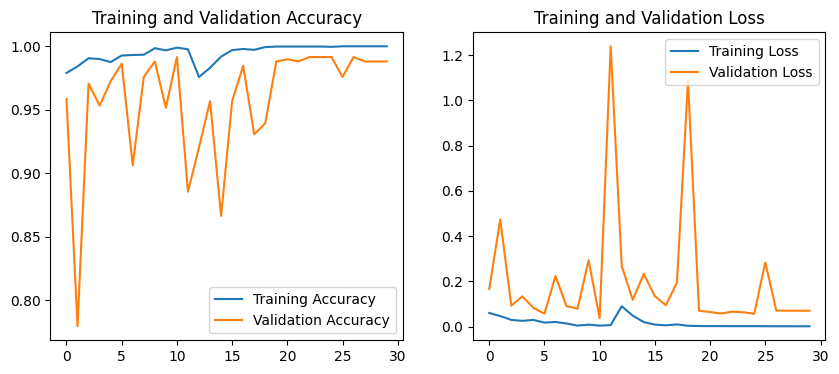

In [75]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Image to Predict
Actual Label: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: PNEUMONIA


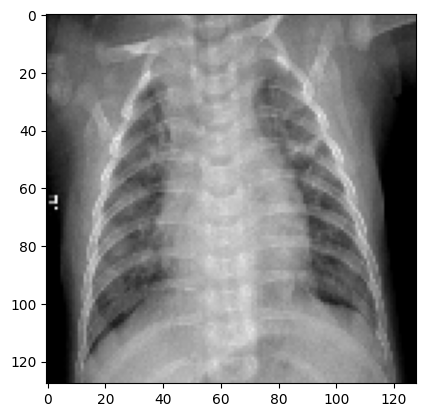

In [76]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    print("Image to Predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[tf.argmax(labels_batch[0]).numpy()])

    batch_prediction = model_1.predict(image_batch)
    print("Predicted Label:", class_names[tf.argmax(batch_prediction[0]).numpy()])

In [77]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)

    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


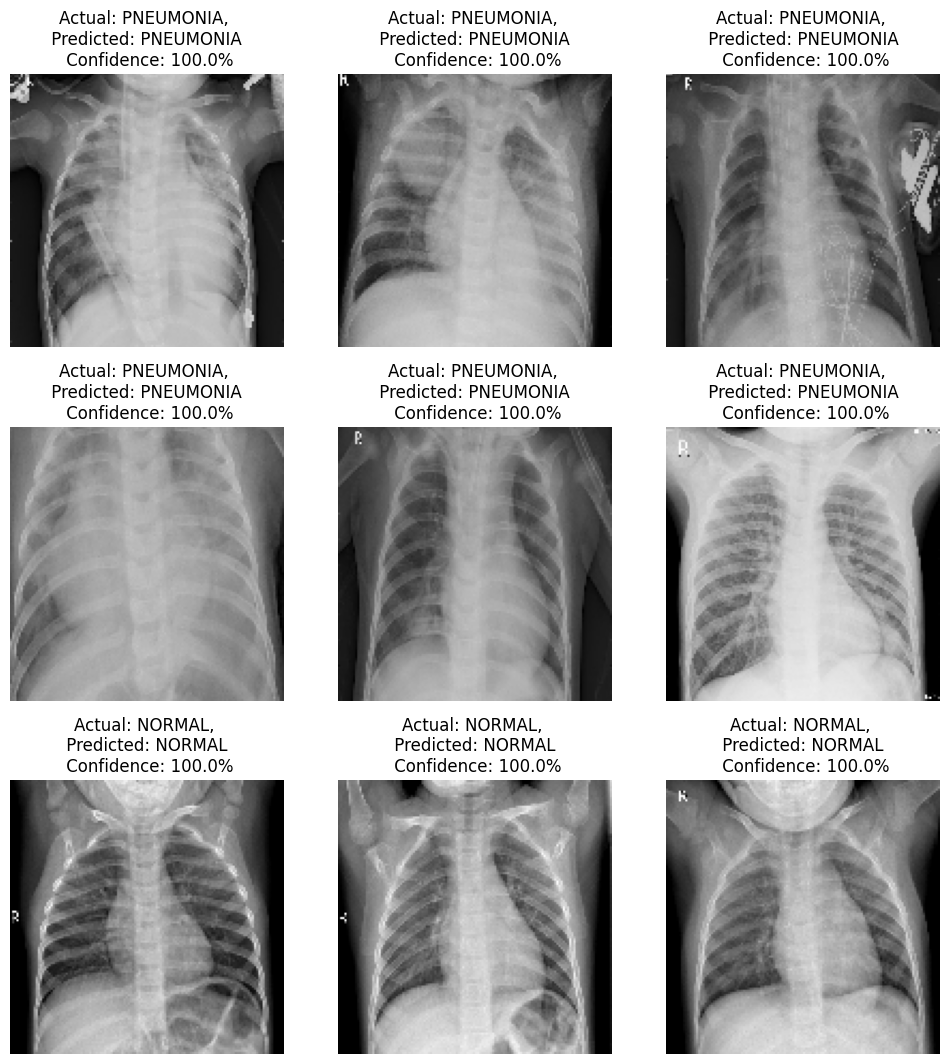

In [78]:
plt.figure(figsize=(12, 13))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model_1, images[i].numpy())

        actual_class = class_names[tf.argmax(labels[i]).numpy()]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")

#### **Save the Model**

In [83]:
if not os.path.exists("models"):
    os.makedirs("models")

model_1.save(f"Best_model.keras")